In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [22]:
# Load the data
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [16]:
# Standardize the activityID column
df_train['activityID'] = df_train['activityID'].astype(str)
df_train['activityID'] = df_train['activityID'].str.strip().str.lower()
#df_val['activityID'] = df_val['activityID'].astype(str)
#df_val['activityID'] = df_val['activityID'].str.strip().str.lower()
df_test['activityID'] = df_test['activityID'].astype(str)
df_test['activityID'] = df_test['activityID'].str.strip().str.lower()

# Encode activityID
label_encoder = LabelEncoder()
df_train['activityID'] = label_encoder.fit_transform(df_train['activityID'])
#df_val['activityID'] = label_encoder.transform(df_val['activityID'])
df_test['activityID'] = label_encoder.transform(df_test['activityID'])


# Split features and target
X_train = df_train.drop(columns=['activityID', 'PeopleId'])
y_train = df_train['activityID']
#X_val = df_val.drop(columns=['activityID', 'PeopleId'])
#y_val = df_val['activityID']
X_test = df_test.drop(columns=['activityID', 'PeopleId'])
y_test = df_test['activityID']

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Compute class weights inversely proportional to class frequencies
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# Map class weights to the corresponding class labels
# class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Update the model parameters to include sample weight
# sample_weights = y_train.map(class_weight_dict)

# Define parameters with very large n_estimators
optimal_params = {
    'colsample_bytree': 0.8, 
    'learning_rate': 0.03, 
    'max_depth': 3, 
    'min_child_weight': 1, 
    'n_estimators': 200,
    'subsample': 0.9
}

# Train model with optimal parameters and early stopping
model = xgb.XGBClassifier(
    **optimal_params,
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    #early_stopping_rounds=50,
    verbose=1
)

# Fit with early stopping
model.fit(
    X_train, y_train,
    #eval_set=[(X_val, y_val)],
    #sample_weight=sample_weights,
    verbose=True
)

# Make predictions
train_preds = model.predict(X_train)
#val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Print accuracies
print(f"Training accuracy: {accuracy_score(y_train, train_preds):.2f}")
#print(f"Validation accuracy: {accuracy_score(y_val, val_preds):.2f}")
print(f"Test accuracy: {accuracy_score(y_test, test_preds):.2f}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Training accuracy: 0.88
Test accuracy: 0.60


In [41]:
activity_mapping = {
    '0': 'Nordic walking',
    '1': 'ascending stairs',
    '2': 'cycling',
    '3': 'descending stairs',
    '4': 'ironing',
    '5': 'Transient Activities',
    '6': 'rope jumping',
    '7': 'running',
    '8': 'sitting',
    '9': 'standing',
    '10': 'transient activities',
    '11': 'vacuum cleaning',
    '12': 'walking'
}

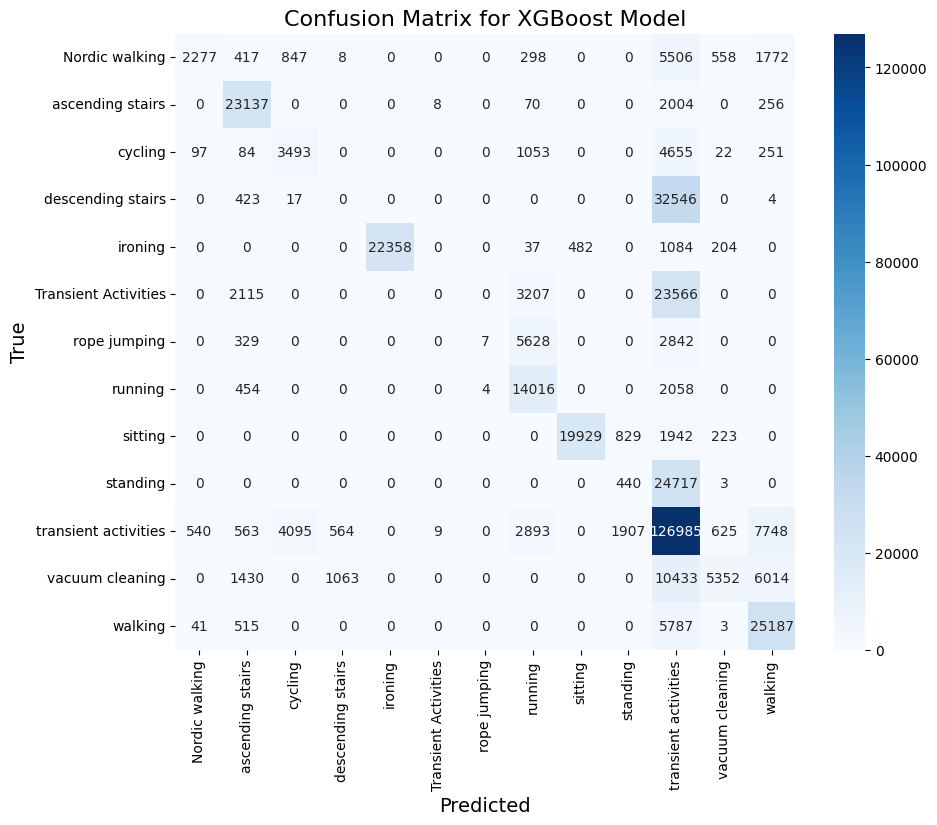

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_mapping.values(),
            yticklabels=activity_mapping.values())
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix for XGBoost Model', fontsize=16)
plt.show()
